In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.datasets import load_iris
import pathlib
from joblib import dump
import pickle
import json
from datetime import datetime


In [2]:
data_iris = load_iris()
X = pd.DataFrame(data_iris.data, columns = data_iris.feature_names)
y = pd.DataFrame(data_iris.target)
display(X)
display(y)
print(data_iris.target_names)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


,0
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


['setosa' 'versicolor' 'virginica']


In [3]:
print(f'Total rows: {len(X)}')
print(f'Columns: {list(X.columns)}')
print(f'Unique target labels: {y[0].unique()}')

Total rows: 150
Columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Unique target labels: [0 1 2]


C:\Users\Habiba\AppData\Local\Temp\ipykernel_15224\3770616284.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


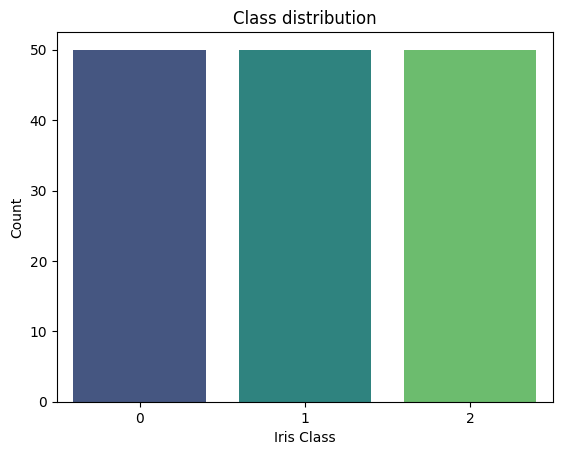

In [4]:
#la distribution des classes 
class_counts = y[0].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class distribution')
plt.xlabel('Iris Class')
plt.ylabel('Count')
plt.show()

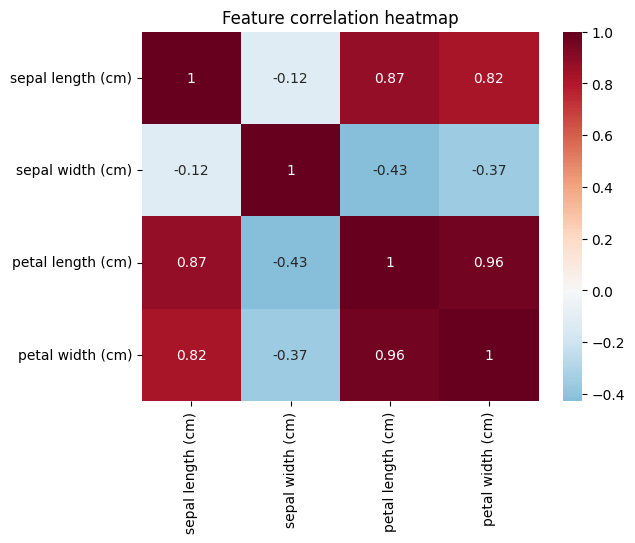

In [5]:
#correlation entre les caracteristiques
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='RdBu_r', center=0, annot=True)
plt.title('Feature correlation heatmap')
plt.show()
#on troue une correlation forte entre petal length et petal width et aussi entre sepal length et petal length

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_iris.data, data_iris.target, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(120, 4) (30, 4)
(120,) (30,)


In [7]:
pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000,solver='lbfgs'))
    ]
)
param_grid = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"CV accuracy: {grid_search.best_score_:.3f}")

Best params: {'clf__C': 10.0, 'clf__penalty': 'l2'}
CV accuracy: 0.967


In [8]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



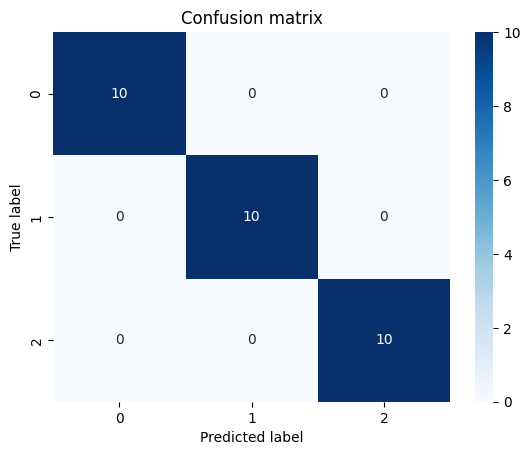

In [9]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [18]:
artifacts_dir = pathlib.Path('..') / 'api'
artifacts_dir.mkdir(parents=True, exist_ok=True)
model_path = artifacts_dir / 'iris_classifier.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(best_model,f)

print(f"Model saved to {model_path.resolve()}")

sample = X_test[[0]]
print('Sample input (first row of test split):')
print(sample)
print(f"Predicted class: {best_model.predict(sample)[0]}")
print(f"Predicted class name: {data_iris.target_names[best_model.predict(sample)[0]]}")

Model saved to C:\Users\Habiba\Desktop\M2\stages\projet\api\iris_classifier.pkl
Sample input (first row of test split):
[[4.4 3.  1.3 0.2]]
Predicted class: 0
Predicted class name: setosa


In [24]:
metadata = {
    "model_name" : "Iris Logistic Regression",
    "training_timestamp": datetime.utcnow().isoformat() + "Z",
    "best_params" : grid_search.best_params_,
    "train_best_score": "{:.3f}".format(grid_search.best_score_),
    "accuracy_score": accuracy_score(y_test, y_pred),
    "class_names": getattr(data_iris, "target_names", ["class_0","class_1","class_2"]).tolist()
}

metadata_path = artifacts_dir / 'model_metadata.json'
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"Metadata saved to {metadata_path.resolve()}")
print("Metadata content:", metadata)

Metadata saved to C:\Users\Habiba\Desktop\M2\stages\projet\api\model_metadata.json
Metadata content: {'model_name': 'Iris Logistic Regression', 'training_timestamp': '2025-10-30T14:32:08.923453Z', 'best_params': {'clf__C': 10.0, 'clf__penalty': 'l2'}, 'train_best_score': '0.967', 'accuracy_score': 1.0, 'class_names': ['setosa', 'versicolor', 'virginica']}
